<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/HUPV/notebooks/solutionscv10_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10. cvičenie - VAE

Na tomto cvičení si prejdeme ako funguje VAE (variational autoencoder) a následne si ho implementujeme.

## VAE - princíp

VEA funguje na princípe enkódera a dekódera. Enkódujeme pôvodný obraz, resp. iný vstup do tzv. latentného priestoru. To nám umožňuje vytvoriť redukciu viacrozmerných dát do menšej dimenzie. Dekóder potom dokáže na vstupe zobrať tieto vektory a vygenerovať pôvodný obraz. Toto sa dá využiť napríklad na generáciu obrázkov z distribúcie datasetu.

Enkóder skonštruujeme ako neurónovú sieť, ktorá vráti parametre distribúcie $q_\theta (z | x)$. Z tejto distribúcie môžeme vybrať vzorku $z$. Túto distribúciu budeme modelovať ako normálnu distribúciu a $\theta$ teda bude reprezentovať parametre $\mu$ a $\sigma$. Teda priemer a stredná odchylka.

Dekóder je potom sieť ktorá na vstup prijme vektor $z$ a na výstupe nám generuje distribúciu $q_\phi (x | z)$. Túto distribúciu potom trénujeme pomocou tzv. max likelihood voči trénovacím dátam. Teda pre $i$-ty príklad z trénovacej množiny. $$C = - \mathbb{E}_{z \sim q_\theta(z|x_i)} log(p_\phi (x_i | z))$$

Prakticky je maximalizácia log-likelihood ekvivalentná s minimalizáciou cross-entropy, alebo inej metriky podľa toho čo predpokladáme o distribúcii $p_\phi$.

Takáto optimalizácia však nestačí. Potrebujeme ešte zabezpečiť aby rozdelenie v latentnom priestore bolo zmysluplné. To zabezpečíme pridaním regularizačného člena tzv. Kullback-Leiblerovej divergenice. Táto metrika nám umožňuje spočítať ako veľmi podobné sú dve rôzne distribúcie. Náš cieľ bude aby distribúcia $q_\theta$ bola čo najbližšia normálnej distribúcii $p(z)$. Teoretické zdôvodnenie môžete nájsť [tu](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/), alebo [tu](https://arxiv.org/pdf/1907.08956.pdf).


$$ C = - \mathbb{E}_{\vec{z} \sim q_\theta(z|\vec{x}_i)} log(p_\phi (\vec{x}_i | \vec{z})) + D_{KL}(q_\theta(\vec{z}|\vec{x}_i) ~||~ p(\vec{z}))$$

$$ D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \mathbb{E}\left[log(q_\theta(\vec{z}|\vec{x})) - log(p(\vec{z}))\right]$$.

Uvažujeme [normálne distribúcie](https://en.wikipedia.org/wiki/Multivariate_normal_distribution):

$$q_\theta(\vec{z}|\vec{x}) = N(\vec{\mu}, \Sigma),~p(\vec{z}) = N(\vec{0},\mathbb{I})$$, $$\Sigma = diag(\sigma_1^2, \sigma_2^2, ..., \sigma_k^2)$$

$$N(\vec{\mu},\Sigma) = \frac{e^{-\frac{1}{2}(\vec{x} - \vec\mu)^T\Sigma^{-1}(\vec{x} - \vec\mu)}}{\sqrt{2 \pi |\Sigma|}}$$

Pre KL divergenciu normálnych distribúcii [platí](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence):


$$D_{KL}(N(\vec\mu_0, \Sigma_0) || N(\vec\mu_1, \Sigma_1)) = \frac{1}{2} \left( tr(\Sigma_1^{-1} \Sigma_0) + (\vec\mu_1 - \vec\mu_0)^T \Sigma_1^{-1}(\vec\mu_1-\vec\mu_0) - k + ln \frac{|\Sigma_1|}{|\Sigma_0|}\right)$$

Teda:

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\left( \sum_{i=1}^k \sigma_i + \sum_{i=1}^k \mu_i^2 - k + log\prod_{i=1}^k \frac{1}{\sigma_i^2} \right)$$

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\sum_{i=1}^k \left(\sigma_i^2 + \mu_i^2 - 1 - log(\sigma_i^2) \right)$$

Z numerických dôvodov je lepšie pracovať v sieti priamo s $log(\sigma_i^2)$ namiesto s $\sigma_i^2$. Ak si zadefinujeme:

$$\lambda_i = log(\sigma_i^2)$$

potom konečne:

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\sum_{i=1}^k \left(e^{\lambda_i} + \mu_i^2 - 1 - \lambda_i \right)$$


## Ako to teda celé bude fungovať?

$\vec\mu$ aj $\vec\lambda$ sa počítajú na základe prvkov $\vec{x}_i$ v minibatchi. Tj. enkóder (sieť) zoberie na vstupe $\vec{x}_i$ a z neho spočíta $\vec{\mu}$ a $\vec\lambda$. Na základe toho sa ako $\vec{z}$ vyberie vzorka z distribúcie $N(\vec{\mu}, \Sigma)$. Tá sa potom vloží do enkódera (opäť sieť) a dostaneme výsledok $\vec{y}$. Sieť potom trénujeme na minibatchi veľkosti $M$ pomocou loss napr. pomocou cross-entropy:

$$ C = \frac{1}{M} \sum_{i = 1}^M CE\left(\vec{y}(\vec{z} \sim N[\vec{\mu}(\vec{x}_i), \Sigma(\vec{x}_i)]), \vec{x}_i \right) + D_{KL}(\vec{\mu}(\vec{x}_i), \Sigma(\vec{x}_i)) $$ 

Posledná vec, ktorú musíme vyriešiť je ako budeme vyberať vzorky $vec{z}$ z distribúcie $N(\vec{\mu}(\vec{x}_i), \Sigma(\vec{x}_i))$ tak, aby sa nám gradienty spropagovali aj do dekódera. Naštastie sa to dá spraviť pomocou vyberania vzoriek z bežnej normálnej distribúcie:

$$ z_j = \mu_j + \sigma_j \cdot N(0,1) = \mu_j + e^{\frac{\lambda_j}{2}} \cdot N(0,1)$$ 

## Diagram VAE

Teraz budete implementovať sieť podľa tohoto diagramu:

![Alt text](https://raw.githubusercontent.com/kocurvik/edu/master/PNSPV/supplementary/ntb_images/VAE_MNIST_small.png)

Máme v podstate tri modely, ktoré zdieaľajú niektoré vrstvy. Na konci samozrejme budete musieť trénovať len VAE model a tie ostatné dva môžete použiť neskôr na inferenciu.

Najprv si samozrejme stiahneme MNIST

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [ ]:
import numpy as np
x = np.array(mnist.data.astype('float32')/255)
labels = np.array(mnist.target.astype('int64'))

x_train = x[:50000]
labels_train = labels[:50000]
x_val = x[50000:60000]
labels_val = labels[50000:60000]
x_test = x[60000:]
labels_test = labels[60000:]

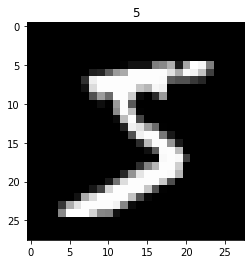

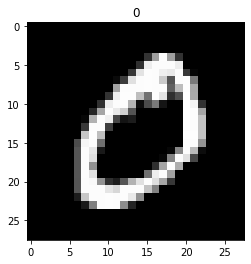

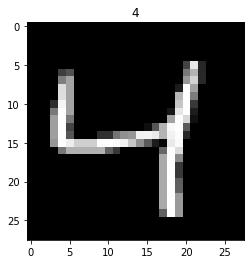

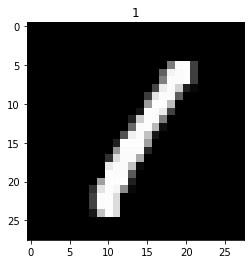

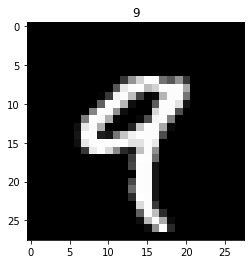

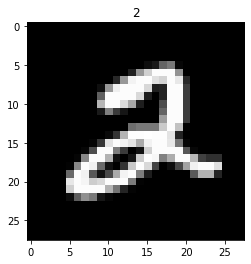

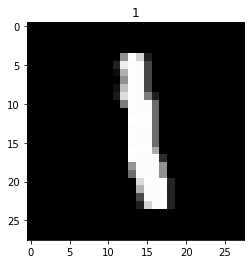

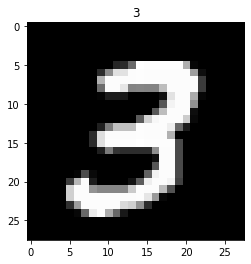

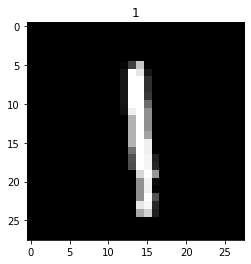

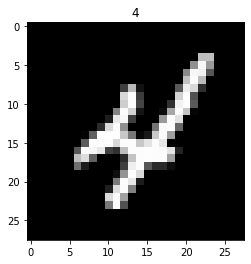

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

for i in range(10):
  plt.imshow(np.reshape(x[i, :],(28,28)), cmap='gray')
  plt.title(labels[i])
  plt.show()

## Náš model VAE

Náš model budeme implementovať podľa nasledovného diagramu:

![Alt text](https://raw.githubusercontent.com/kocurvik/edu/master/PNSPV/supplementary/ntb_images/VAE_MNIST_small.png)

Model bude máť nasledovné metódy#
*   Konštruktor
*   `encode`
*   `sample_z`
*   `encode_pred`
*   `decode`
*   `compute_loss` 

V konštruktore určíme n_hidden a n_z a nainicializujeme jednotlivé vrstvy. Obrázok je pre keras, takže ak je niekde určená vrstva Dense, tak použijeme linear a pridáme aktivačnú funkciu podľa farby.


Naimplementujeme metódu `encode`, ktorá bude mať na vstupe vždy vstupný tenzor veľkosti $n \times 784$. Na výstupe vráti tenzory $\lambda$ a $\mu$ oba veľkosť $n \times n_z$. V samotnej štruktúre použite diagram.

Ďalej naimplementujeme metódu `sample_z`, ktorá bude mať na vstupe tenzory $\lambda$ a $\mu$, ktoré určia paramtre distribúcie a jednotlivé elementy $z$ potom dostaneme zo vzorca:

$$ z_j = \mu_j + \sigma_j \cdot N(0,1) = \mu_j + e^{\frac{\lambda_j}{2}} \cdot N(0,1),$$ 

pričom $N(0, 1)$ bude náhodné číslo z normálnej distribúcie. Na výstupe potom bude tenzor $z$ s veľkosťou $n \times n_z$. Pamätajte, že ak vygenerujete náhodný tenzor musíte ho potom poslať na správny device aby to fungovalo.

V kóde je aj predpripravená metóda `encode_predict`, ktorá len kombinujé metódy `encode` a `sample_z`. Táto metóda v podstate realizuje zelenú časť výpočtu z diagramu.

Ako ďalší naimplementujeme metódu `decode`, ktorá na vstupe dostane tenzor $z$ s veľkosťou $n \times n_z$ a vráti obrázok. Táto metóda realizuje modrú časť výpočtu v diagrame.

Nakoniec naimplementujeme metódu compute_loss ktorá zavolá dostane vstupný tenzor veľkosti $n \times 784$ s obrázkom MNISTU endcode, sample_z a decode a z medzihodnôt vráti cenovú funkciu:

$$ C = - \mathbb{E}_{\vec{z} \sim q_\theta(z|\vec{x}_i)} log(p_\phi (\vec{x}_i | \vec{z})) + D_{KL}(q_\theta(\vec{z}|\vec{x}_i) ~||~ p(\vec{z})),$$

pričom prvý člen je vlastne binary crossentropy medzi výstupom z enkóderu a vstupom do dekóderu a druhým člen má tvar

$$D_{KL}(q_\theta(\vec{z}|\vec{x}) ~||~ p(\vec{z})) = \frac{1}{2}\sum_{i=1}^k \left(e^{\lambda_i} + \mu_i^2 - 1 - \lambda_i \right)$$

*Pozn.:* Pri počítaní loss budete používať torch.nn.BCELoss. V konštruktore ale použite `reduction='sum'` aby sme sa vyhli [tomuto problému.](https://stackoverflow.com/questions/50607516/variational-autoencoder-gives-same-output-image-for-every-input-mnist-image-when)

In [ ]:
import torch
from torch.nn import Linear
from torch.nn.functional import relu

class VAE(torch.nn.Module):
  def __init__(self, n_z, n_hidden):
    super(VAE, self).__init__()
    self.n_z = n_z
    self.n_hidden = n_hidden

    self.linear_encoder = Linear(784, n_hidden)
    self.linear_lambda = Linear(n_hidden, n_z)
    self.linear_mu = Linear(n_hidden, n_z)

    self.linear_decoder = Linear(n_z, n_hidden)
    self.linear_out = Linear(n_hidden, 784)
    self.bce_loss = torch.nn.BCELoss(reduction='sum')

  def encode(self, x):
    h = self.linear_encoder(x)
    h = relu(h)
    lam = self.linear_lambda(h)
    mu = self.linear_mu(h)

    return lam, mu

  def sample_z(self, lam, mu):
    n = torch.randn(lam.size()).to(lam.device)
    z = mu + n * torch.exp(lam / 2)
    return z

  def encode_pred(self, x):
    lam, mu = self.encode(x)
    z = self.sample_z(lam, mu)
    return z
  
  def decode(self, z):
    h = self.linear_decoder(z)
    h = relu(h)
    return torch.sigmoid(self.linear_out(h))

  def compute_loss(self, x):
    lam, mu = self.encode(x)
    z = self.sample_z(lam, mu)
    out = self.decode(z)

    loss = self.bce_loss(out, x)
    loss += 0.5 * torch.mean(torch.sum(torch.exp(lam) + mu ** 2 - 1 - lam, dim = -1))
    return loss

Nasledujúci kód by vám mal cca zbehnúť o overiť že váš kód aspoň približne robí čo má.

In [ ]:
vae = VAE(7, 64)

r_inp = torch.rand(16, 784)
lam, mu = vae.encode(r_inp)
print("Chceme size 16, 7 pre lam, mu, z")
print(lam.size(), mu.size())
z = vae.sample_z(lam, mu)
print(z.size())

out = vae.decode(z)
print("Chceme size 16, 784")
print(out.size())

print("Chceme size 16, 7 pre z")
z_direct = vae.encode_pred(r_inp)
print(z_direct.size())


print("Loss by mala byť skalárna")
loss = vae.compute_loss(r_inp)
print(loss)

Chceme size 16, 7 pre lam, mu, z
torch.Size([16, 7]) torch.Size([16, 7])
torch.Size([16, 7])
Chceme size 16, 784
torch.Size([16, 784])
Chceme size 16, 7 pre z
torch.Size([16, 7])
Loss by mala byť skalárna
tensor(8787.5703, grad_fn=<AddBackward0>)


Sieť si môžeme natrénovať.

In [ ]:
batch_size = 32

dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(x_train))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)

vae = VAE(2, 64).cuda()

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

for e in range(10):
  running_loss = 0
  train_losses = []
  for i, sample in enumerate(dataloader_train):
    optimizer.zero_grad()
    
    loss = vae.compute_loss(sample[0].cuda())
    
    loss.backward()
    
    optimizer.step()
    
    running_loss = 0.9 * running_loss + 0.1 * loss.item()
    train_losses.append(loss.item())
    
    if i % 100 == 99:
      print("At step {} running loss: {}".format(i + 1, running_loss))
    
  print('*' * 20)

  print("After epoch {} mean train loss: {}".format(e, np.mean(train_losses)))

At step 100 running loss: 15920.589671930244
At step 200 running loss: 10085.137525019813
At step 300 running loss: 7918.755999312058
At step 400 running loss: 7489.497949214581
At step 500 running loss: 7018.953513237741
At step 600 running loss: 6773.986883149108
At step 700 running loss: 7040.0884215991555
At step 800 running loss: 6904.6452797792535
At step 900 running loss: 6861.378876185416
At step 1000 running loss: 6480.552238738738
At step 1100 running loss: 6496.345416133709
At step 1200 running loss: 6419.14831014203
At step 1300 running loss: 6527.6805780938685
At step 1400 running loss: 6301.128193458118
At step 1500 running loss: 6365.8083812611085
********************
After epoch 0 mean train loss: 7874.23895931427
At step 100 running loss: 6134.14781383905
At step 200 running loss: 6240.31836923025
At step 300 running loss: 6251.455926188547
At step 400 running loss: 6356.544003338739
At step 500 running loss: 6106.8578474310725
At step 600 running loss: 5998.7242680903

## Generácia obrázkov

tensor([[-1.6279, -0.6684]])


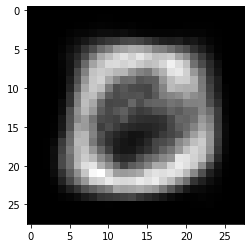

tensor([[-2.3487, -0.4075]])


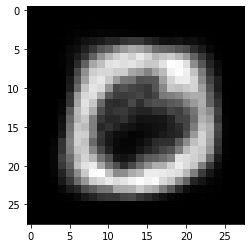

tensor([[-0.2144, -1.5075]])


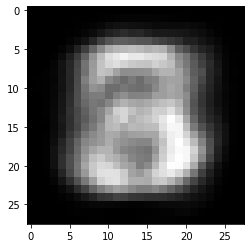

tensor([[0.4125, 0.4954]])


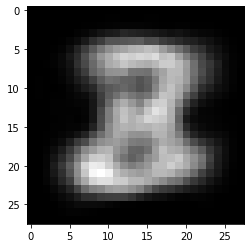

tensor([[-0.2464, -0.2817]])


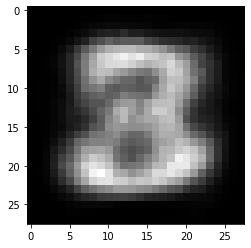

tensor([[0.4428, 1.4349]])


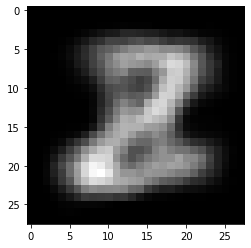

tensor([[-0.2104, -0.3148]])


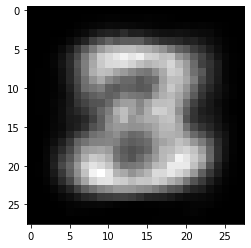

tensor([[0.5296, 0.3657]])


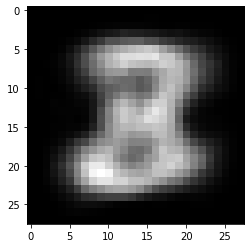

tensor([[-1.6550,  2.1140]])


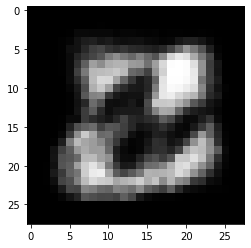

tensor([[ 1.6228, -1.3723]])


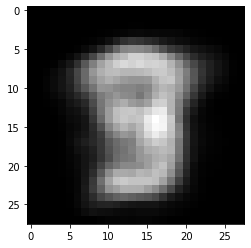

In [ ]:
with torch.no_grad():
  for i in range(10):
    z_example = torch.randn(1,2)
    print(z_example)
    prediction = vae.decode(z_example.cuda())
    plt.imshow(np.reshape(prediction[0].detach().cpu().numpy(), [28, 28]), cmap='gray')
    plt.show()

## Distribúcia v latentnom priestore

Môžeme si aj zobraziť ako vyzerá latentný priestor z ak si vykreslíme kde sa nachádazajú latente vektory pre rôzne cifry.

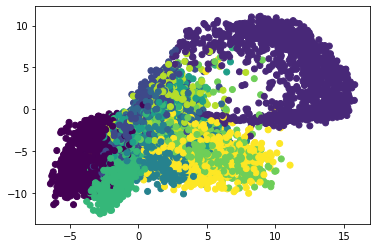

In [ ]:
for i in range(10000//32):
  prediction = vae.encode_pred(torch.from_numpy(x_test[i*32:(i+1)*32, :]).cuda())
  prediction = prediction.detach().cpu().numpy()
  if i == 0:
    z_list = prediction
  else:
    z_list = np.row_stack([z_list, prediction])

plt.scatter(z_list[:, 0], z_list[:, 1], c = labels_test[:len(z_list)])
plt.show()

Môžme to skúsiť aj na trénovacej množine.

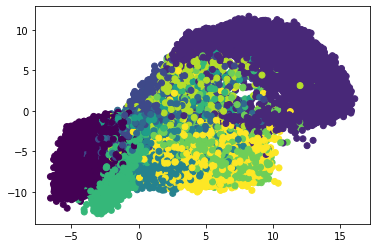

In [ ]:
for i in range(50000//32):
  prediction = vae.encode_pred(torch.from_numpy(x_train[i*32:(i+1)*32, :]).cuda())
  prediction = prediction.detach().cpu().numpy()
  if i == 0:
    z_list = prediction
  else:
    z_list = np.row_stack([z_list, prediction])

plt.scatter(z_list[:, 0], z_list[:, 1], c = labels_train[:len(z_list)])
plt.show()

## Vizualizácia obrázkov v latentnom priestore

Môžeme si taktiež zobraziť obrázky generované pre jednotlivé z z latentného priestoru tak že budeme postupne meniť z-ové hodnoty.

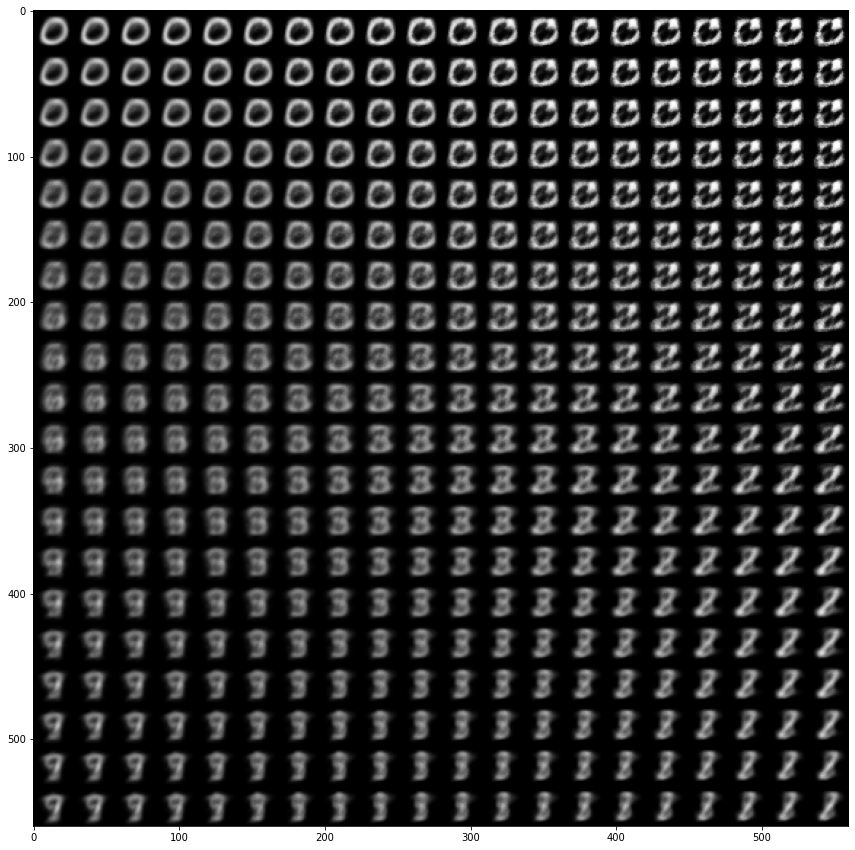

In [ ]:
n_images = 20

final_image = np.zeros([28*n_images,28*n_images])

for i, z1 in enumerate(np.linspace(-3, 3, n_images)):
  for j, z2 in enumerate(np.linspace(-3, 3, n_images)):
    prediction = vae.decode(torch.tensor([[z1, z2]]).float().cuda())
    final_image[i*28:(i+1)*28, j*28:(j+1)*28] = np.reshape(prediction[0].detach().cpu().numpy(), [28, 28])

plt.figure(figsize = (15, 15))
plt.imshow(final_image, cmap='gray')
plt.show()

## 3D vizualizácia

Môžeme si obdobné veci zobraziť aj v 3D. Najprv si natrénujeme model a potom robíme zobrazenia.

Tento kód vytvoril Filip Pavlove v rámci náhrady DÚ: 
https://github.com/kocurvik/edu/blob/master/HUPV/notebooks/pytorch/cv10-solution.ipynb



In [ ]:
batch_size = 32

dataset_train = torch.utils.data.TensorDataset(torch.from_numpy(x_train))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)

vae3 = VAE(3, 64).cuda()

optimizer = torch.optim.Adam(vae3.parameters(), lr=1e-4)

for e in range(10):
  running_loss = 0
  train_losses = []
  for i, sample in enumerate(dataloader_train):
    optimizer.zero_grad()
    
    loss = vae3.compute_loss(sample[0].cuda())
    
    loss.backward()
    
    optimizer.step()
    
    running_loss = 0.9 * running_loss + 0.1 * loss.item()
    train_losses.append(loss.item())
    
    if i % 100 == 99:
      print("At step {} running loss: {}".format(i + 1, running_loss))
    
  print('*' * 20)

  print("After epoch {} mean train loss: {}".format(e, np.mean(train_losses)))

At step 100 running loss: 15791.153080396034
At step 200 running loss: 9845.980473597096
At step 300 running loss: 7765.3265838840225
At step 400 running loss: 7407.968425580146
At step 500 running loss: 6953.16119615891
At step 600 running loss: 6746.721920209691
At step 700 running loss: 7024.444404901793
At step 800 running loss: 6910.976902761456
At step 900 running loss: 6900.16166652456
At step 1000 running loss: 6525.925999520234
At step 1100 running loss: 6537.555895904577
At step 1200 running loss: 6469.737286942234
At step 1300 running loss: 6571.767236500567
At step 1400 running loss: 6311.841351338007
At step 1500 running loss: 6386.014179391271
********************
After epoch 0 mean train loss: 7848.193369371801
At step 100 running loss: 6128.961248592354
At step 200 running loss: 6191.558239986534
At step 300 running loss: 6175.994441944703
At step 400 running loss: 6224.8891824293005
At step 500 running loss: 5963.315778813261
At step 600 running loss: 5815.081526731176

In [ ]:
for i in range(10000//32):
  prediction = vae3.encode_pred(torch.from_numpy(x_test[i*32:(i+1)*32, :]).cuda())
  prediction = prediction.detach().cpu().numpy()
  if i == 0:
    z_list = prediction
  else:
    z_list = np.row_stack([z_list, prediction])


import plotly.graph_objects as go

x, y, z = z_list[:, 0], z_list[:, 1], z_list[:, 2]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(
        size=1,
        color=labels_test[:len(z_list)].flatten(),
        colorscale='Viridis',
        opacity=0.8
    ))])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Môžme si cez slidre aj meniť čísielká.

In [ ]:
%%capture
%matplotlib inline
from ipywidgets import interact, widgets
from IPython.display import display


def f(z1, z2, z3):
    prediction = vae3.decode(torch.tensor([[z1/100, z2/100, z3/100]]).float().cuda())
    ax.imshow(np.reshape(prediction[0].detach().cpu().numpy(), [28, 28]), cmap="gray")
    fig.canvas.draw()
    display(fig)

fig = plt.figure(figsize=(6, 4))
ax  = fig.add_subplot(111)

prediction = vae3.decode(torch.tensor([[0, 0, 0]]).float().cuda())
ax.imshow(np.reshape(prediction[0].detach().cpu().numpy(), [28, 28]), cmap="gray")

In [ ]:
interact(f, z1=widgets.IntSlider(min=-600,max=600,step=2,value=0),
            z2=widgets.IntSlider(min=-600,max=600,step=2,value=0),
            z3=widgets.IntSlider(min=-600,max=600,step=2,value=0))

interactive(children=(IntSlider(value=0, description='z1', max=600, min=-600, step=2), IntSlider(value=0, desc…

<function __main__.f>